In [2]:
import load_ppe_fun as lp
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from time import sleep
import pickle
import warnings
import re
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import itertools

In [3]:
vnum='0001'
nikki = '2025-08-26'
target_nikki = 'target'
sim_config = 'condcoal_r1'
l_cic = True
target_simconfig = 'condcoal_dt5'

momxy = '46'
plot_dir = 'plots/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

n_init = 2
target_mp = 'BIN_TAU' + momxy
do_reload = False
# obtaining case related variables
mconfigs = os.listdir(lp.output_dir + nikki)

vars_strs, vars_vn = lp.get_dics(lp.output_dir, target_nikki, target_simconfig, n_init)
mps, nmp = lp.get_mps(lp.output_dir, nikki, sim_config, l_cic, vars_strs, momxy)
mps = lp.sort_strings_by_number(mps)
# var_interest = [4, 9] # see lp.indvar_ename_set
# var_interest = [127, 128, 129, 130]
# var_interest = [131, 132, 133, 134] # mean_V_M0, mean_V_M3, mean_V_Mx, mean_V_My
# var_interest = [139, 140, 141] # mean_dm0_coal, mean_dmx_coal, mean_dmy_coal
# var_interest = [123, 124, 125, 126]
# var_interest = [108, 95, 107, 121, 122]
var_interest = [95, 107, 121, 122] # mean_LWP, mean_LNP, mean_Mx_path, mean_My_path
# var_interest = [92, 108, 123, 124, 125, 126]
# var_interest = [106, 107] # see lp.indvar_ename_set
# var_interest = [107, 121, 122] # mean LNP, Mx path, My path
# var_interest = [2,3,4] # see lp.indvar_ename_set
indvar_names = [lp.indvar_name_set[idx] for idx in var_interest]
indvar_enames = [lp.indvar_ename_set[idx] for idx in var_interest]
indvar_units = [lp.indvar_units_set[idx] for idx in var_interest]

file_info = {'dir': lp.output_dir, 
             'date': nikki, 
             'version_number': vnum,
             'vars_vn': vars_vn}

nc_dict = {}
data_range = {}


In [7]:
import importlib
importlib.reload(lp)

<module 'load_ppe_fun' from '/home/arthurhu/BOSS_PPE/load_ppe_fun.py'>

In [4]:
# data_range_pkl_fn = lp.output_dir + nikki + '/' + sim_config + '_dr_' + str(var_interest) + '.pkl'
ic_str = 'cic'
file_info.update({'sim_config': sim_config})
for imp, mp in enumerate(tqdm(mps, desc='loading PPEs')):
    file_info['mp_config'] = mp
    lin_or_log = lp.load_KiD(file_info, var_interest, nc_dict, data_range, continuous_ic=l_cic)

loading PPEs: 100%|██████████| 5000/5000 [00:33<00:00, 148.28it/s]


In [5]:
# load BIN_TAU
for combo in itertools.product(*vars_strs):
    ic_str = "".join(combo)
    file_info.update({'sim_config': target_simconfig,
                      'vars_str': list(combo),
                      'date': target_nikki,
                      'mp_config': target_mp})
    lin_or_log = \
            lp.load_KiD(file_info, var_interest, nc_dict, data_range, False)

In [6]:
float_re = re.compile(r'(\d+(?:\.\d+)?)$')  # match digits, optional .digits, at end

def numeric_key(s):
    # Find the first sequence of digits in the string
    m = float_re.search(s)
    return float(m.group(1)) if m else 0.0

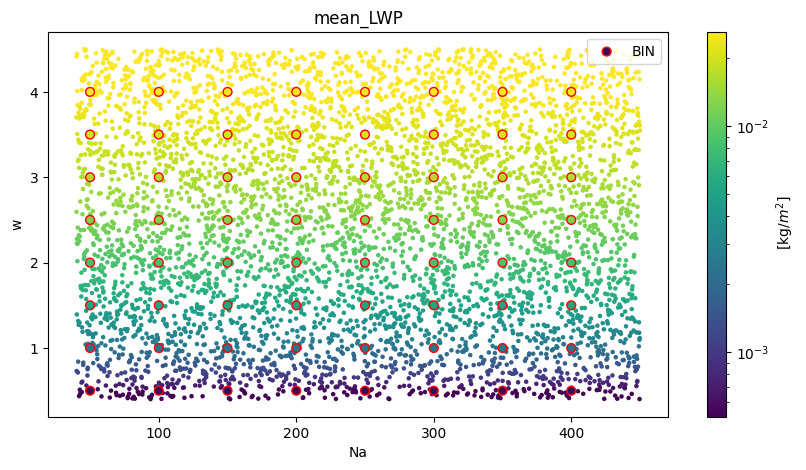

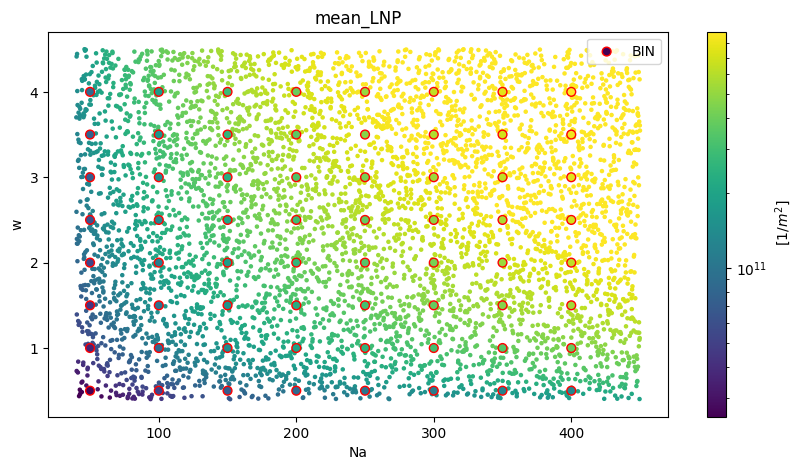

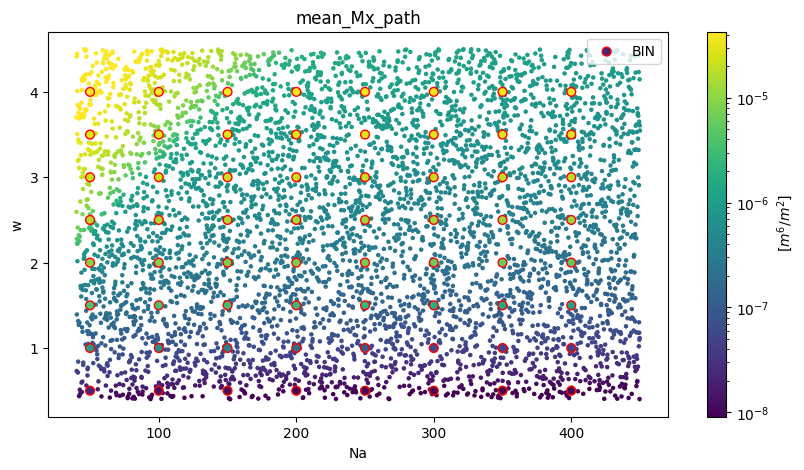

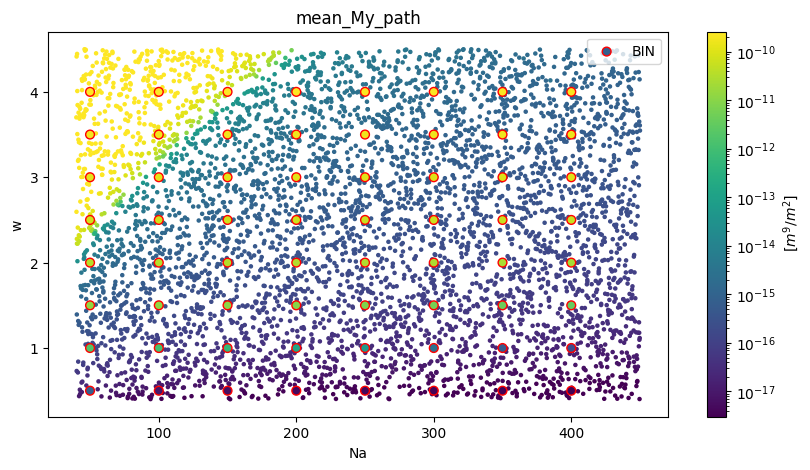

In [7]:
if n_init == 1:
    # meanLWP_BOSS = [nc_dict['cic'][mp]['mean_LWP'] for mp in mps]
    # meanLWP_bin = [nc_dict[w]['BIN_TAU']['mean_LWP'] for w in vars_strs[0]]
    for i, (var_ename, var_units) in enumerate(zip(indvar_enames, indvar_units)):
        plt.figure()
        var_interest_val = []
        ind_var_val = []
    
        boss_var_interest_val = []
        boss_ind_var_val = []
        for combo in itertools.product(*vars_strs):
            ic_str = "".join(combo)
            ind_var_val.append(numeric_key(combo[0]))
            var_interest_val.append(nc_dict[ic_str][target_mp][var_ename])
        for imp, mp in enumerate(mps):
            boss_var_interest_val.append(nc_dict['cic'][mp][var_ename])
            boss_ind_var_val.append(nc_dict['cic'][mp][vars_vn[0]])
        # plt.scatter(meanLWP_BOSS, boss_var_interest_val, c='tab:orange', alpha=0.1, label='BOSS')
        # plt.plot(meanLWP_bin, var_interest_val, label='bin')
        plt.scatter(boss_ind_var_val, boss_var_interest_val, c='tab:orange', alpha=0.1, label='BOSS')
        plt.plot(ind_var_val, var_interest_val, label='bin')
        plt.legend()
        plt.title(var_ename + var_units)
        plt.xlabel(vars_vn[0])
        plt.xscale('log')
        # plt.yscale('log')
        # if i>1: plt.yscale('log')
        plt.savefig(plot_dir + sim_config + '_' + var_ename + '.pdf')
elif n_init == 2:
    var1_vn = re.search(r'^[A-Z]*[a-z]*', vars_strs[0][0])[0]
    var2_vn = re.search(r'^[A-Z]*[a-z]*', vars_strs[1][0])[0]
    
    ic1_boss = np.zeros(nmp)
    ic2_boss = np.zeros(nmp)
    var_boss = np.zeros(nmp)
    for var_ename, var_units in zip(indvar_enames, indvar_units):
        if l_cic: 
            ic_str = 'cic'
            for imp, mp in enumerate(mps):
                ic1_boss[imp] = nc_dict[ic_str][mp][var1_vn]
                ic2_boss[imp] = nc_dict[ic_str][mp][var2_vn]
                var_boss[imp] = nc_dict[ic_str][mp][var_ename]
                
        ic1_tau = np.array([])
        ic2_tau = np.array([])
        var_tau = np.array([])
        for combo in itertools.product(*vars_strs):
            ic_str = "".join(combo)
            ic1_tau = np.append(ic1_tau, nc_dict[ic_str][target_mp][var1_vn])
            ic2_tau = np.append(ic2_tau, nc_dict[ic_str][target_mp][var2_vn])
            var_tau = np.append(var_tau, nc_dict[ic_str][target_mp][var_ename])
    
        # vmax = np.max(np.concatenate((var_boss, var_tau)))
        # vmin = np.min(np.concatenate((var_boss, var_tau)))
        vmax = np.max(var_tau)
        vmin = np.min(var_tau)

        if vmin > 0:
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        # norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
        plt.figure(figsize=(10, 5))
        plt.scatter(ic1_boss, ic2_boss, c=var_boss, s=5, norm=norm)
        plt.scatter(ic1_tau, ic2_tau, c=var_tau, s=40, edgecolors=[1, 0, 0], norm=norm, label='BIN')
        plt.legend(loc='upper right')
        plt.title(var_ename)
        plt.xlabel(vars_vn[0])
        plt.ylabel(vars_vn[1])
        # plt.xscale('log')
        plt.colorbar(label=var_units)
        # plt.savefig(plot_dir + sim_config + '_' + var_ename + '.pdf')

In [18]:
nc_dict.keys()

dict_keys(['time', 'z', 'Na50w0.5', 'Na50w1', 'Na50w1.5', 'Na50w2', 'Na50w2.5', 'Na50w3', 'Na50w3.5', 'Na50w4', 'Na100w0.5', 'Na100w1', 'Na100w1.5', 'Na100w2', 'Na100w2.5', 'Na100w3', 'Na100w3.5', 'Na100w4', 'Na150w0.5', 'Na150w1', 'Na150w1.5', 'Na150w2', 'Na150w2.5', 'Na150w3', 'Na150w3.5', 'Na150w4', 'Na200w0.5', 'Na200w1', 'Na200w1.5', 'Na200w2', 'Na200w2.5', 'Na200w3', 'Na200w3.5', 'Na200w4', 'Na250w0.5', 'Na250w1', 'Na250w1.5', 'Na250w2', 'Na250w2.5', 'Na250w3', 'Na250w3.5', 'Na250w4', 'Na300w0.5', 'Na300w1', 'Na300w1.5', 'Na300w2', 'Na300w2.5', 'Na300w3', 'Na300w3.5', 'Na300w4', 'Na350w0.5', 'Na350w1', 'Na350w1.5', 'Na350w2', 'Na350w2.5', 'Na350w3', 'Na350w3.5', 'Na350w4', 'Na400w0.5', 'Na400w1', 'Na400w1.5', 'Na400w2', 'Na400w2.5', 'Na400w3', 'Na400w3.5', 'Na400w4'])